# FDN Reverberator - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: 10557065, MATR: 953546 )

In [82]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import scipy as sp
import IPython.display as ipd

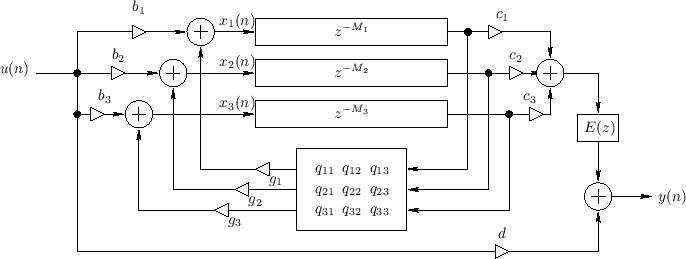

In [83]:
ipd.Image(filename = "images/FDNScheme.png")

## Params

In [84]:
fs = 22050
N = 4
g = np.ones(N) # cambia come vuoi

t60 = 1 # reverberation time
# TODO: reverberation time should be function of frequency! from 0 to fs/2
K = 7
t60 = np.repeat(1.5, K) #! constant, need to create a graphic 'eq' to select t60
t60 = [1, 0.9, 1, 0.5, 0.4, 0.2, 0.1]
freqs = np.array([0, fs/(2*6), 2*fs/(2*6), 3*fs/(2*6), 4*fs/(2*6), 5*fs/(2*6), fs/2])
print(t60) 

# Min delay lenght
# TODO: create slider to select length (starting from min)
M_min = int(np.ceil(0.15*np.max(t60)*fs))
print(M_min)

[1, 0.9, 1, 0.5, 0.4, 0.2, 0.1]
3308


In [85]:
primeN = []

for num in range(2,101):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
       primeN.append(num)

M = []
for i in primeN:
    m = np.floor(0.5+np.log(M_min)/np.log(i))
    if i**m>M_min:
        M.append(int(i**m))

M = np.sort(M)

M = M[:N]

print(M)
# TODO: select numbers according to min desired length

[3481 3721 4096 4489]


## Lossless Feedback Matrix

Hadamard Matrix

In [86]:
if((N & (N-1) == 0) and N != 0):
    Had = 1/np.sqrt(N)*sp.linalg.hadamard(N)
    print(Had)


[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


Householder Matrix

In [87]:
u = np.ones(N)
Hous = np.identity(N)-2/N*u*u.T
print(Hous)

[[ 0.5 -0.5 -0.5 -0.5]
 [-0.5  0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5 -0.5]
 [-0.5 -0.5 -0.5  0.5]]


## Delay IR

In [88]:
u = [1, 0, 0, 0]


D = np.zeros((N, M[-1]+len(u)))

for i in range(N):
    D[i, M[i]-1] = 1



In [89]:
#Circuit
#Parameter initialization
U = [1, 0, 0, 0]
B = [1,1,1]
C = [1,1,1]
G = [1,1,1]
A = Hous
'''                                          1 2 3 4
#Delay lines data structure initialization   _ _ _ _  list of vectors
                                             | | | |
                                             | | | |
'''
delay_lines=[]
delay_outputs=[]
for i in range(N):
    delay_lines.append(np.zeros(M[i]))


for u in U: # For every sample of the input
    for i in range(N): # For every circuit calculate output of delay lines and shift
        delay_outputs.append(delay_lines[i][-1])
        delay_lines[1:M[i]-1] = delay_lines[i][0:M[i]-2]
    
    delay_outputs_array=np.asanyarray(delay_outputs)
    delay_output_mixed = A*delay_outputs_array # calculate feedback with the selected mixing matrix

    Output = np.sum(np.multiply(delay_outputs_array, C)) # Calculate Output to E(z)

    for i in range(N):
        delay_lines[i][0] = B[i]*u + G[i] * delay_output_mixed[i] # insert the calculated input+feedback value into the first position of each delay line


IndexError: invalid index to scalar variable.

Once we have delayed the splitted signal, apply a filter (to each delay line). This filter is used to determine the $t_{60}$ of the reverb in each frequency band.

In [90]:
def plotFilter(w, h, M_i):
        fig, ax1 = plt.subplots()
        ax1.set_title('Filter applied to delay line with M={}'.format(M_i))
        ax1.plot(w, 20 * np.log10(abs(h)), 'b')
        ax1.set_ylabel('Amplitude [dB]', color='b')
        ax1.set_xlabel('Frequency [rad/sample]')
        # ax2 = ax1.twinx()
        # angles = np.unwrap(np.angle(h))
        # ax2.plot(w, angles, 'g')
        # ax2.set_ylabel('Angle (radians)', color='g')
        # ax2.grid()
        # ax2.axis('tight')
        plt.show()

In [91]:
# Case 1: Simple 1st order filter

def filter1st(x, M, t60, fs):
    for M_i in M:
        R_M = []
        # R_M = 1-(6.91*M_i/t60*fs)
        for t60_f in t60:
            R_M.append(10**((-3*M_i)/(t60_f*fs))) 
            
        print(R_M)

        # pole
        p_i = (R_M[0]-R_M[-1])/(R_M[0]+R_M[-1])

        # gain
        g_i = 2*(R_M[0]*R_M[-1])/(R_M[0]+R_M[-1])

        print(g_i, p_i)

        b = [0, g_i]
        a = [-p_i, 1]

        w, h = sp.signal.freqz(b,a, fs=fs)

        plotFilter(w, h, M_i)


In [92]:
# Case 2: Orthogonalized 1st order delay filter
def ortFilter1st(x, M, t60, fs):
    for M_i in M:

        # gain
        g_i = 10**((-3*M_i)/(t60[0]*fs))

        # pole and zero
        p_i = np.log(10)/4 * np.log10(g_i) * (1-(1/(t60[-1]/t60[0])**2))

        print(g_i, p_i)

        b = [0, g_i*(1-p_i)]
        a = [-p_i, 1]

        w, h = sp.signal.freqz(b,a, fs=fs)

        plotFilter(w, h, M_i)


In [93]:
# Case 3: Multiband filter design (preferred)
def multibandEqualizer(x, M, K, freqs, fs):
    for M_i in M:

        G_i = []
        # evaluate correct gains (one per band)
        for t60_f in t60:
            G_i.append(10**((-3*M_i)/(t60_f*fs))) 

        
        print(G_i)

        taps = sp.signal.firwin2(numtaps=K, freq=freqs, gain=G_i, fs=fs)

        w, h = sp.signal.freqz(taps, fs=fs)

        plotFilter(w, h, M_i)

Spectral coloration equalizer

In [94]:
# coefficient of the filter:
def spectralEqualizer(x, t60, fs):
    b_coeff = (1-(t60[-1]/t60[0]))/(1+(t60[-1]/t60[0]))

    b = [-b_coeff, 1]
    a = [0, 1-b_coeff]

    w, h = sp.signal.freqz(b,a, fs=fs)

    fig, ax1 = plt.subplots()
    ax1.set_title('Spectral Coloration Equalizer')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    # ax2 = ax1.twinx()
    # angles = np.unwrap(np.angle(h))
    # ax2.plot(w, angles, 'g')
    # ax2.set_ylabel('Angle (radians)', color='g')
    # ax2.grid()
    # ax2.axis('tight')
    plt.show()

# Main:

[0.33604277145703, 0.2976951305764875, 0.33604277145703, 0.1129247442485217, 0.06546156661504722, 0.004285216703696265, 1.8363082197637484e-05]


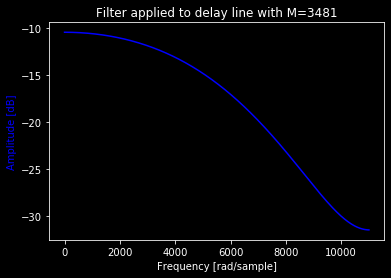

[0.31170336920701036, 0.27383600596645863, 0.31170336920701036, 0.09715899037500181, 0.05424425407530436, 0.0029424391001861734, 8.657947858304417e-06]


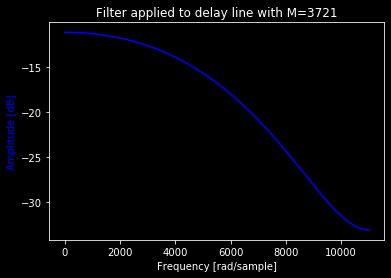

[0.27715396014362303, 0.2403262497249127, 0.27715396014362303, 0.07681431762329298, 0.04043921542341571, 0.0016353301440614233, 2.6743046800759556e-06]


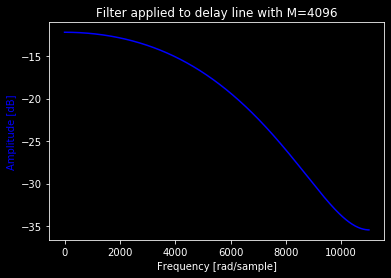

[0.24504830377994255, 0.2095997587963373, 0.24504830377994255, 0.060048671185427005, 0.029725505699158283, 0.0008836056890706915, 7.807590137580916e-07]


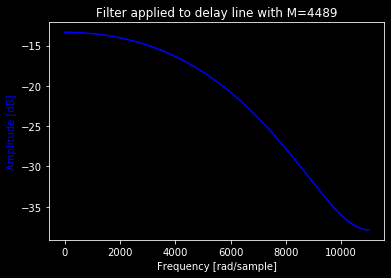

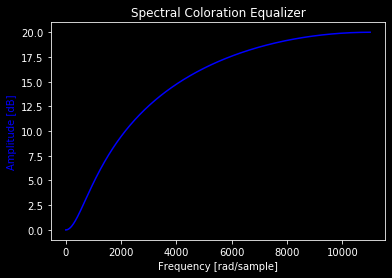

In [95]:
# parameters:


# initialize: input signal u, feedback = 0


# feedback loop (for each sample):
    # here we have x as sum of input and feedback

    # apply the delays to x

    # apply the filters to x
x=0
multibandEqualizer(x, M, K, freqs, fs)

    # take the result and apply the feedback matrix, loop back

    # take x and write the result into a buffer 

# take the output from the buffer and apply the equalization filter
spectralEqualizer(x, t60, fs)

# blend the result with original signal